In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt

random_seed = 42

## Data

In [2]:
df = pd.read_csv("hf://datasets/SIH/palmer-penguins/penguins.csv")
df.head(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


## Preprocessing

In [3]:
le = LabelEncoder()
scaler = StandardScaler()
categorical_columns = ['species', 'island', 'sex', 'year']
numerical_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
target = 'species'
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode(dropna=True).iloc[0])
df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].mean())
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
for cat in categorical_columns:
    df[cat] = le.fit_transform(df[cat])

In [4]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,0,2,-8.870812e-01,0.787743,-1.422488,-0.565789,1,0
1,0,2,-8.134940e-01,0.126556,-1.065352,-0.503168,0,0
2,0,2,-6.663195e-01,0.431719,-0.422507,-1.192003,0,0
3,0,2,-1.307172e-15,0.000000,0.000000,0.000000,1,0
4,0,2,-1.328605e+00,1.092905,-0.565361,-0.941517,0,0


In [5]:
y = df[target].to_numpy()
X = df.drop(columns=target).to_numpy()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
print(f'X_train.shape: {X_train.shape},\nX_test.shape: {X_test.shape},\ny_train.shape: {y_train.shape},\ny_test.shape: {y_test.shape}')

X_train.shape: (275, 7),
X_test.shape: (69, 7),
y_train.shape: (275,),
y_test.shape: (69,)


## Model training

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from boosting import GradientBoosting
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

my_clf = GradientBoosting(n_estimators=10, learning_rate=0.1, max_depth=3, random_state=random_seed)
sklearn_clf = GradientBoostingClassifier(n_estimators=10, learning_rate=0.1, max_depth=3, random_state=random_seed)
xgb_clf = XGBClassifier(n_estimators=10, random_state=random_seed)

In [8]:
my_scores = cross_val_score(my_clf, X_train, y_train, cv=cv, scoring='accuracy')
sklearn_scores = cross_val_score(sklearn_clf, X_train, y_train, cv=cv, scoring='accuracy')
xgb_scores = cross_val_score(xgb_clf, X_train, y_train, cv=cv, scoring='accuracy')


my_clf.fit(X_train, y_train)
sklearn_clf.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=10,
              n_jobs=None, num_parallel_tree=None, ...)

## Inference & metrics

In [9]:
print(f'My Accuracy: {my_scores.mean():.4f} ± {my_scores.std():.4f}')
print(f'Sklearn Accuracy: {sklearn_scores.mean():.4f} ± {sklearn_scores.std():.4f}')
print(f'XGB Accuracy: {xgb_scores.mean():.4f} ± {xgb_scores.std():.4f}')

My Accuracy: 0.9491 ± 0.0212
Sklearn Accuracy: 0.9636 ± 0.0230
XGB Accuracy: 0.9673 ± 0.0212


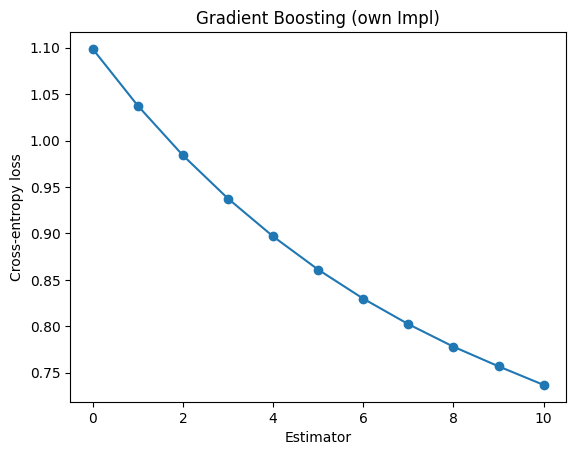

In [10]:
plt.plot(my_clf._losses, marker='o')
plt.xlabel('Estimator')
plt.ylabel('Cross-entropy loss')
plt.title('Gradient Boosting (own Impl)')
plt.show()

In [11]:
my_pred = my_clf.predict(X_test)
sklearn_pred = sklearn_clf.predict(X_test)
xgb_pred = xgb_clf.predict(X_test)

print('MyImpl classification report')
print(classification_report(y_test, my_pred))

print('Sklearn classification report')
print(classification_report(y_test, sklearn_pred))

print('XGB classification report')
print(classification_report(y_test, xgb_pred))

MyImpl classification report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        32
           1       0.93      1.00      0.96        13
           2       1.00      1.00      1.00        24

    accuracy                           0.99        69
   macro avg       0.98      0.99      0.98        69
weighted avg       0.99      0.99      0.99        69

Sklearn classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        24

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69

XGB classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00 